### Import libs

In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
from models import *
import torch
import torch.optim
from torch.utils.data import Dataset
from torch import tensor
import time
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *

import seaborn as sns

from nni.retiarii.evaluator.pytorch import Lightning, Trainer, LightningModule
from nni.retiarii.evaluator.pytorch.lightning import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

from typing import Any

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# display images
def np_plot(np_matrix, title):
    plt.clf()
    fig = plt.imshow(np_matrix.transpose(1, 2, 0), interpolation = 'nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)
    plt.axis('off')
    plt.pause(0.05) 

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print('CUDA available: {}'.format(torch.cuda.is_available()))

CUDA available: True


### Load images

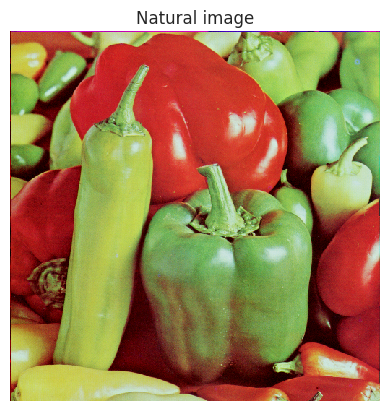

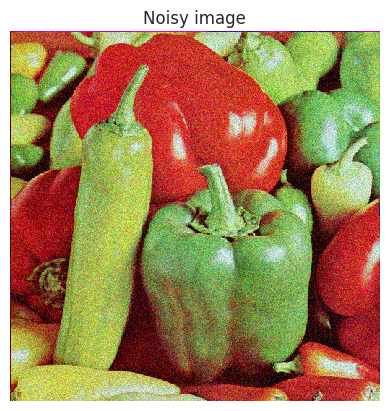

In [2]:
fname = 'data/denoising/Dataset/image_Peppers512rgb.png'
imsize =-1
sigma = 25/255.
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)                
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma)
np_plot(img_np, 'Natural image')
np_plot(img_noisy_np, 'Noisy image')

### Hyper-parameters

In [3]:
INPUT = 'noise'
pad = 'reflection'
OPT_OVER = 'net' # optimize over the net parameters only
reg_noise_std = 1./30.
learning_rate = LR = 0.01
exp_weight=0.99
input_depth = 32 
roll_back = True # to prevent numerical issues
num_iter = 20000 # max iterations
burnin_iter = 7000 # burn-in iteration for SGLD
weight_decay = 5e-8
show_every =  500
mse = torch.nn.MSELoss().type(dtype) # loss
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

## SGLD Pytorch Lightning Module

In [ ]:


# SGLD Pytorch Lightning Module
class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary??)
        return self.image

class SGLD(LightningModule):
    def __init__(self, 
        original_np,
        noisy_np,
        noisy_torch
    ):
        super().__init__()
        print('CUDA available: {}'.format(torch.cuda.is_available()))
        print(f'DTYPE: {dtype}')
        self.automatic_optimization = False

        # iterators
        self.burnin_iter=7000 # burn-in iteration for SGLD
        self.show_every=500
        self.num_iter=20000

        # backtracking
        self.psrn_noisy_last=0
        self.last_net = None
        self.roll_back = True # To solve the oscillation of model training 

        # SGLD Output Accumulation
        self.sgld_mean=0
        self.sgld_mean_each=0
        self.sgld_psnr_list = [] # psnr between sgld out and gt
        self.MCMC_iter=50
        self.param_noise_sigma=2

        # tinker with image input
        self.img_np = original_np           
        self.img_noisy_np = noisy_np
        self.img_noisy_torch = noisy_torch
        
        # network input
        self.input_depth = 32
        self.model = get_net(
                    self.input_depth, 
                    'skip', 
                    'reflection',
                    skip_n33d=128, 
                    skip_n33u=128,
                    skip_n11=4,
                    num_scales=5,
                    upsample_mode='bilinear'
                ).type(self.dtype)
        self.net_input = get_noise(self.input_depth, 'noise', (img_np.shape[-2:][1], img_np.shape[-2:][0])).type(self.dtype).detach()
        self.net_input_saved = self.net_input.detach().clone()
        self.noise = self.net_input.detach().clone()
        
        # closure
        self.reg_noise_std = tensor(1./30.)
        self.criteria = torch.nn.MSELoss().type(dtype) # loss

        # optimizer
        self.learning_rate = 0.01
        self.weight_decay = 5e-8

    ## SGLD
    def add_noise(self, net):
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            noise = torch.randn(n.size())*self.param_noise_sigma*self.learning_rate
            noise = noise.type(dtype)
            n.data = n.data + noise

    def forward(self, net_input_saved):
        if self.reg_noise_std > 0:
            self.net_input = self.net_input_saved + (self.noise.normal_() * self.reg_noise_std)
            return self.model(self.net_input)
        else:
            return self.model(net_input_saved)

    def closure_sgld(self):
        out = self.forward(self.net_input)
        total_loss = self.criteria(out, self.img_noisy_torch)
        total_loss.backward()
        out_np = out.detach().cpu().numpy()[0]

        psrn_noisy = compare_psnr(self.img_noisy_np, out.detach().cpu().numpy()[0])
        psrn_gt    = compare_psnr(self.img_np, out_np)

        self.sgld_psnr_list.append(psrn_gt)

        # Backtracking
        if self.roll_back and self.i % self.show_every:
            if psrn_noisy - self.psrn_noisy_last < -5: 
                print('Falling back to previous checkpoint.')
                for new_param, net_param in zip(self.last_net, self.model.parameters()):
                    net_param.detach().copy_(new_param.cuda())
                return total_loss*0
            else:
                self.last_net = [x.detach().cpu() for x in model.parameters()]
                self.psrn_noisy_last = psrn_noisy

        if self.i % self.show_every == 0:
            np_plot(out.detach().cpu().numpy()[0], 'Iter: %d; gt %.2f' % (self.i, psrn_gt))
        
        if self.i > self.burnin_iter and np.mod(self.i, self.MCMC_iter) == 0:
            self.sgld_mean += out_np
            self.sample_count += 1.

        if self.i > self.burnin_iter:
            self.sgld_mean_each += out_np
            sgld_mean_tmp = self.sgld_mean_each / (self.i - self.burnin_iter)
            self.sgld_mean_psnr_each = compare_psnr(self.img_np, self.sgld_mean_tmp)
            self.sgld_psnr_mean_list.append(self.sgld_mean_psnr_each) # record the PSNR of avg after burn-in
            print('Iter: %d; psnr_gt %.2f; psnr_sgld %.2f' % (self.i, psrn_gt, self.sgld_mean_psnr_each))
        else:
            print('Iter: %d; psnr_gt %.2f; loss %.5f' % (self.i, psrn_gt, total_loss))
        
        if self.i == self.burnin_iter:
            print('Burn-in done, start sampling')

        self.i += 1
        return total_loss

    def configure_optimizers(self) -> Optimizer:
        """
        We are doing a manual implementation of the SGLD optimizer
        There is a SGLD optimizer that can be found here:
            - https://pysgmcmc.readthedocs.io/en/pytorch/_modules/pysgmcmc/optimizers/sgld.html
            - Implementing this would greatly affect the training step
                - But could it work?? :`( I couldn't figure it out
        """
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def train_dataloader(self):
        """
        Trick this puppy into thinking we have a dataloader
        It's a single image for deep image priors
        So we just need to return a dataloader with a single image
        """
        dataset = SingleImageDataset(self.img_np, self.num_iter)
        return DataLoader(dataset, batch_size=1)

    def on_train_start(self) -> None:
        """
        Move all tensors to the GPU to begin training
        Initialize Iterators
        Set Sail
        """
        self.model.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)

        self.net_input_saved = self.net_input.clone().to(self.device)
        self.noise = self.net_input.clone().to(self.device)
        
        # Initialize Iterations
        self.i=0
        self.sample_count=0

        # bon voyage
        print('Starting optimization with SGLD')

    def training_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Oh the places you'll go
        ---> Straight to error city calling this add_noise in the training step
        ---> Consider using the on_train_batch_end hook? (each batch is only one iteration)
        """
        optimizer = self.optimizers()
        optimizer.zero_grad()
        loss = self.closure_sgld()
        optimizer.step()
        self.add_noise(model)
        return loss

    def on_train_end(self) -> None:
        """
        May all your dreams come true
        """
        self.sgld_mean = self.sgld_mean / self.sample_count
        np_plot(selfsgld_mean.detach().cpu().numpy()[0], 'Final after %d iterations' % (self.i))
        


def image_unpack(fname, imsize=-1, sigma=25/255):
    dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    img_pil = crop_image(get_image(fname, imsize)[0], d=32) 
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma)
    img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
    
    return {
        'original_pil': img_pil,
        'original_np': img_np,
        'noisy_pil': img_noisy_pil, 
        'noisy_np': img_noisy_np,
        'noisy_torch': img_noisy_torch
    }


# choose iterations
num_iter = 20000 # max iterations

# get image
fname = 'data/denoising/Dataset/image_Peppers512rgb.png'
img_dict = image_unpack(fname)
original_pil = img_dict['original_pil']
original_np = img_dict['original_np'] 
noisy_pil = img_dict['noisy_pil']
noisy_np = img_dict['noisy_np']
noisy_torch = img_dict['noisy_torch']


# reference model
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor  
model = get_net(
                32, 
                'skip', 
                'reflection',
                skip_n33d=128, 
                skip_n33u=128,
                skip_n11=4,
                num_scales=5,
                upsample_mode='bilinear'
            ).type(dtype)

# Create the lightning module
module = SGLD(
        original_np=original_np,
        noisy_np=noisy_np,
        noisy_torch=noisy_torch)

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=num_iter,
            fast_dev_run=False,
            gpus=1,
            checkpoint_callback=False
            )

# Initialize ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath='./{lightning_logs}/{logger_name}/version_{version}/checkpoints/',
    filename='{epoch}-{step}',
    every_n_epochs=500,
    save_top_k=1,
)

# Add the checkpoint callback to trainer
trainer.callbacks.append(checkpoint_callback)
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []

# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(noisy_np, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(noisy_np, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)
lightning.fit(model)

## phantom

In [ ]:


# SGLD Pytorch Lightning Module
class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary??)
        return self.image

class SGLD(LightningModule):
    def __init__(self, 
        original_np,
        noisy_np,
        noisy_torch
    ):
        super().__init__()
        print('CUDA available: {}'.format(torch.cuda.is_available()))
        print(f'DTYPE: {dtype}')
        self.automatic_optimization = False

        # iterators
        self.burnin_iter=7000 # burn-in iteration for SGLD
        self.show_every=500
        self.num_iter=20000

        # backtracking
        self.psrn_noisy_last=0
        self.last_net = None
        self.roll_back = True # To solve the oscillation of model training 

        # SGLD Output Accumulation
        self.sgld_mean=0
        self.sgld_mean_each=0
        self.sgld_psnr_list = [] # psnr between sgld out and gt
        self.MCMC_iter=50
        self.param_noise_sigma=2

        # tinker with image input
        self.img_np = original_np           
        self.img_noisy_np = noisy_np
        self.img_noisy_torch = noisy_torch
        
        # network input
        self.input_depth = 32
        self.model = get_net(
                    self.input_depth, 
                    'skip', 
                    'reflection',
                    skip_n33d=128, 
                    skip_n33u=128,
                    skip_n11=4,
                    num_scales=5,
                    upsample_mode='bilinear'
                ).type(self.dtype)
        self.net_input = get_noise(self.input_depth, 'noise', (img_np.shape[-2:][1], img_np.shape[-2:][0])).type(self.dtype).detach()
        self.net_input_saved = self.net_input.detach().clone()
        self.noise = self.net_input.detach().clone()
        
        # closure
        self.reg_noise_std = tensor(1./30.)
        self.criteria = torch.nn.MSELoss().type(dtype) # loss

        # optimizer
        self.learning_rate = 0.01
        self.weight_decay = 5e-8
        
        # burnin-end criteria
        self.img_collection = []
        self.var_history = []
        self.patience = 1000
        self.wait_count = 0
        self.best_score = float('inf')
        self.best_epoch = 0
        self.img_collection = []
        self.burnin_over = False
        self.buffer_size = 100

    ## SGLD
    def add_noise(self, net):
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            noise = torch.randn(n.size())*self.param_noise_sigma*self.learning_rate
            noise = noise.type(dtype)
            n.data = n.data + noise

    def forward(self, net_input_saved):
        if self.reg_noise_std > 0:
            self.net_input = self.net_input_saved + (self.noise.normal_() * self.reg_noise_std)
            return self.model(self.net_input)
        else:
            return self.model(net_input_saved)

    def closure_sgld(self):
        out = self.forward(self.net_input)
        total_loss = self.criteria(out, self.img_noisy_torch)
        total_loss.backward()
        out_np = out.detach().cpu().numpy()[0]

        psrn_noisy = compare_psnr(self.img_noisy_np, out.detach().cpu().numpy()[0])
        psrn_gt    = compare_psnr(self.img_np, out_np)

        self.sgld_psnr_list.append(psrn_gt)

        ###
        ###
        ###

        # update img collection
        v_img_np = out_np.reshape(-1)
        self.update_img_collection(v_img_np)
        img_collection = self.get_img_collection()

        # if len(img_collection) == self.buffer_size:
        if len(img_collection) >= self.buffer_size:
            # update variance and var history
            ave_img = np.mean(img_collection, axis=0)
            variance = [MSE(ave_img, tmp) for tmp in img_collection]
            self.cur_var = np.mean(variance)
            self.variance_history.append(self.cur_var)
            self.check_stop(self.cur_var, self.i)

        ###
        ###
        ###

        # Backtracking
        if self.roll_back and self.i % self.show_every:
            if psrn_noisy - self.psrn_noisy_last < -5: 
                print('Falling back to previous checkpoint.')
                for new_param, net_param in zip(self.last_net, self.model.parameters()):
                    net_param.detach().copy_(new_param.cuda())
                return total_loss*0
            else:
                self.last_net = [x.detach().cpu() for x in model.parameters()]
                self.psrn_noisy_last = psrn_noisy

        if self.i % self.show_every == 0:
            np_plot(out.detach().cpu().numpy()[0], 'Iter: %d; gt %.2f' % (self.i, psrn_gt))
        
        if self.burnin_over and np.mod(self.i, self.MCMC_iter) == 0:
            self.sgld_mean += out_np
            self.sample_count += 1.

        if self.burnin_over:
            self.sgld_mean_each += out_np
            sgld_mean_tmp = self.sgld_mean_each / (self.i - self.burnin_iter)
            self.sgld_mean_psnr_each = compare_psnr(self.img_np, self.sgld_mean_tmp)
            self.sgld_psnr_mean_list.append(self.sgld_mean_psnr_each) # record the PSNR of avg after burn-in
            print('Iter: %d; psnr_gt %.2f; psnr_sgld %.2f' % (self.i, psrn_gt, self.sgld_mean_psnr_each))
        else:
            print('Iter: %d; psnr_gt %.2f; loss %.5f' % (self.i, psrn_gt, total_loss))
        
        if self.i == self.burnin_iter:
            print('Burn-in done, start sampling')

        self.i += 1
        return total_loss

    def configure_optimizers(self) -> Optimizer:
        """
        We are doing a manual implementation of the SGLD optimizer
        There is a SGLD optimizer that can be found here:
            - https://pysgmcmc.readthedocs.io/en/pytorch/_modules/pysgmcmc/optimizers/sgld.html
            - Implementing this would greatly affect the training step
                - But could it work?? :`( I couldn't figure it out
        """
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def train_dataloader(self):
        """
        Trick this puppy into thinking we have a dataloader
        It's a single image for deep image priors
        So we just need to return a dataloader with a single image
        """
        dataset = SingleImageDataset(self.img_np, self.num_iter)
        return DataLoader(dataset, batch_size=1)

    def on_train_start(self) -> None:
        """
        Move all tensors to the GPU to begin training
        Initialize Iterators
        Set Sail
        """
        self.model.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)

        self.net_input_saved = self.net_input.clone().to(self.device)
        self.noise = self.net_input.clone().to(self.device)
        
        # Initialize Iterations
        self.i=0
        self.sample_count=0

        # bon voyage
        print('Starting optimization with SGLD')

    def training_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Oh the places you'll go
        ---> Straight to error city calling this add_noise in the training step
        ---> Consider using the on_train_batch_end hook? (each batch is only one iteration)
        """
        optimizer = self.optimizers()
        optimizer.zero_grad()
        loss = self.closure_sgld()
        optimizer.step()
        self.add_noise(model)
        return loss

    def on_train_end(self) -> None:
        """
        May all your dreams come true
        """
        self.sgld_mean = self.sgld_mean / self.sample_count
        np_plot(selfsgld_mean.detach().cpu().numpy()[0], 'Final after %d iterations' % (self.i))

    def check_stop(self, current, cur_epoch):
        # using an early stopper technique to determine when to end the burn in phase for SGLD
        if current < self.best_score:
            self.best_score = current
            self.best_epoch = cur_epoch
            self.wait_count = 0
            self.burnin_over = False
        else:
            self.wait_count += 1
            self.burnin_over = self.wait_count >= self.patience
        # return burnin_over

    def update_img_collection(self, cur_img):
        self.img_collection.append(cur_img)
        if len(self.img_collection) > self.buffer_size:
            self.img_collection.pop(0)

    def get_img_collection(self):
        return self.img_collection

    def MSE(self, x1, x2):
        return ((x1 - x2) ** 2).sum() / x1.size
        


def image_unpack(fname, imsize=-1, sigma=25/255):
    dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    img_pil = crop_image(get_image(fname, imsize)[0], d=32) 
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma)
    img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
    
    return {
        'original_pil': img_pil,
        'original_np': img_np,
        'noisy_pil': img_noisy_pil, 
        'noisy_np': img_noisy_np,
        'noisy_torch': img_noisy_torch
    }


# choose iterations
num_iter = 20000 # max iterations

# get image
fname = 'data/denoising/Dataset/image_Peppers512rgb.png'
img_dict = image_unpack(fname)
original_pil = img_dict['original_pil']
original_np = img_dict['original_np'] 
noisy_pil = img_dict['noisy_pil']
noisy_np = img_dict['noisy_np']
noisy_torch = img_dict['noisy_torch']


# reference model
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor  
model = get_net(
                32, 
                'skip', 
                'reflection',
                skip_n33d=128, 
                skip_n33u=128,
                skip_n11=4,
                num_scales=5,
                upsample_mode='bilinear'
            ).type(dtype)

# Create the lightning module
module = SGLD(
        original_np=original_np,
        noisy_np=noisy_np,
        noisy_torch=noisy_torch)

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=num_iter,
            fast_dev_run=False,
            gpus=1,
            checkpoint_callback=False
            )

# Initialize ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath='./{lightning_logs}/{logger_name}/version_{version}/checkpoints/',
    filename='{epoch}-{step}',
    every_n_epochs=500,
    save_top_k=1,
)

# Add the checkpoint callback to trainer
trainer.callbacks.append(checkpoint_callback)
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []

# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(noisy_np, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(noisy_np, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)
lightning.fit(model)

In [ ]:
# add this logic to closure
# instead of early stopping, we'll let this indicate the burn-in period is complete

# if should_stop:
#     self.burnin = False

self.img_collection = []
self.var_history = []

# update img collection
v_img_np = out_np.reshape(-1)
self.update_img_collection(v_img_np)
img_collection = self.get_img_collection()

# if len(img_collection) == self.buffer_size:
if len(img_collection) >= self.buffer_size:
    # update variance and var history
    ave_img = np.mean(img_collection, axis=0)
    variance = [MSE(ave_img, tmp) for tmp in img_collection]
    self.cur_var = np.mean(variance)
    self.variance_history.append(self.cur_var)



class EarlyStop():
    def __init__(self, buffer_size, patience):

        # burnin-end criteria
        self.patience = patience
        self.wait_count = 0
        self.best_score = float('inf')
        self.best_epoch = 0
        self.img_collection = []
        self.stop = False
        self.buffer_size = buffer_size

    def check_stop(self, current, cur_epoch):
      #stop when variance doesn't decrease for consecutive P(patience) times
        if current < self.best_score:
            self.best_score = current
            self.best_epoch = cur_epoch
            self.wait_count = 0
            should_stop = False
        else:
            self.wait_count += 1
            should_stop = self.wait_count >= self.patience
        return should_stop

    def update_img_collection(self, cur_img):
        self.img_collection.append(cur_img)
        if len(self.img_collection) > self.size:
            self.img_collection.pop(0)

    def get_img_collection(self):
        return self.img_collection

    def MSE(self, x1, x2):
        return ((x1 - x2) ** 2).sum() / x1.size